# Australian Renewable Energy Generation


The aim of this project is to predict how much power a wind or solar farm will generate based on weather conditions.

Below is a time-series visualisation of renewable energy generation in Australia.


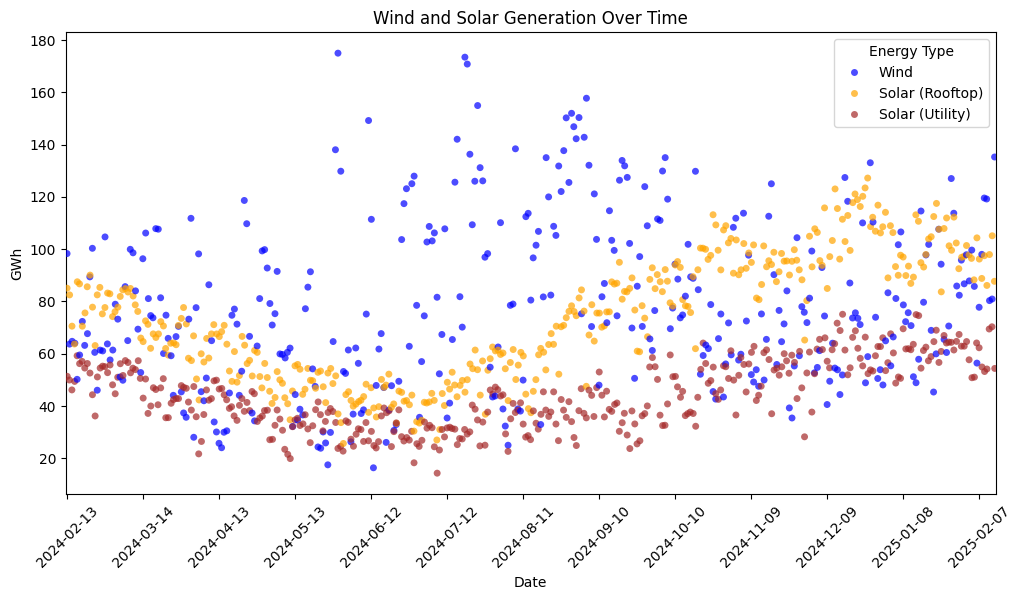

In [224]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

csv_path = os.path.join("SavedData", "2024EnergyGenerationAus.csv")
EnergyGeneration_df = pd.read_csv(csv_path)

# Visualizing the "Wind - GWh" and "Solar (Rooftop) - GWh" columns over time
# Ensure the date or time column is in datetime format & add DOY column
EnergyGeneration_df['Date'] = pd.to_datetime(EnergyGeneration_df['date'])
EnergyGeneration_df['DOY'] = EnergyGeneration_df['Date'].dt.dayofyear

# Reshape data to long format for Wind and Solar
EnergyGeneration_df_long = EnergyGeneration_df.melt(
    id_vars='Date', 
    value_vars=['Wind -  GWh', 'Solar (Rooftop) -  GWh', 'Solar (Utility) -  GWh'], 
    var_name='Energy Type', 
    value_name='GWh'
)

# Simplify energy type labels
EnergyGeneration_df_long['Energy Type'] = EnergyGeneration_df_long['Energy Type'].str.replace(' -  GWh', '')

# Plot using stripplot
plt.figure(figsize=(12, 6))
sns.stripplot(
    x='Date', 
    y='GWh', 
    hue='Energy Type', 
    data=EnergyGeneration_df_long, 
    jitter=True, 
    alpha=0.7, 
    palette={'Wind': 'blue', 'Solar (Rooftop)': 'orange', 'Solar (Utility)': 'brown'}
)

# Adding plot labels and title
plt.title('Wind and Solar Generation Over Time')
plt.xlabel('Date')
plt.ylabel('GWh')
plt.xticks(rotation=45)
plt.legend(title='Energy Type')
plt.xticks(ticks=plt.xticks()[0][::30], rotation=45)

# Show plot
plt.show()

Use OpenElectricity API to get historic QLD wind & solar data.

In [248]:
import os
import requests
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path

# Define paths
saved_data_dir = Path('SavedData')
forecast_csv_path = saved_data_dir / 'TrainGenerationHistoric.csv'

# Ensure the directory exists
saved_data_dir.mkdir(exist_ok=True)

# Check if the file already exists
if forecast_csv_path.exists():
    print("File exists. Loading data from CSV...")
    EnergyGeneration_df = pd.read_csv(forecast_csv_path, parse_dates=['Date'])
else:
    print("File not found. Fetching data from API...")

    # Load the OE API token from the .env file
    load_dotenv()
    token = os.getenv("OPENELECTRICITY_API_KEY")

    # Define the API endpoint and parameters
    api_url = "https://api.openelectricity.org.au/v4/data/network/NEM"
    params = {
        "interval": "1d",
        "date_start": "2024-02-10",
        "date_end": "2025-02-09",
        "primary_grouping": "network_region",
        "metrics": "energy",
        "secondary_grouping": "fueltech_group"
    }

    # Set the headers with the bearer token
    headers = {"Authorization": f"Bearer {token}"}

    # Fetch the data from the API
    response = requests.get(api_url, params=params, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()
    else:
        raise RuntimeError(f"Failed to fetch data: {response.status_code}")

    # Filter for Queensland's solar and wind energy data
    solar_data = []
    wind_data = []

    for item in data.get('data', []):
        for result in item.get('results', []):
            if result['columns']['region'] == 'QLD1':
                if result['columns']['fueltech_group'] == 'solar':
                    for entry in result['data']:
                        solar_data.append({'Date': entry[0], 'Solar (Utility) - GWh': entry[1] / 1000})
                elif result['columns']['fueltech_group'] == 'wind':
                    for entry in result['data']:
                        wind_data.append({'Date': entry[0], 'Wind - GWh': entry[1] / 1000})

    # Convert to DataFrames
    solar_df = pd.DataFrame(solar_data)
    wind_df = pd.DataFrame(wind_data)

    # Merge data on Date
    EnergyGeneration_df = pd.merge(solar_df, wind_df, on='Date', how='outer')
    EnergyGeneration_df['Date'] = pd.to_datetime(EnergyGeneration_df['Date'])
    EnergyGeneration_df['DOY'] = EnergyGeneration_df['Date'].dt.dayofyear

    # Save to CSV for future use
    EnergyGeneration_df.to_csv(forecast_csv_path, index=False)
    print(f"Data saved to {forecast_csv_path}")


File exists. Loading data from CSV...


Use Open-Meteo API to get history weather condition data.

In [253]:
import os
import openmeteo_requests
import requests_cache
import pandas as pd
import numpy as np
import pytz
from retry_requests import retry
from pathlib import Path

# Define paths
saved_data_dir = Path('SavedData')
weather_csv_path = saved_data_dir / 'TrainWeatherHistoric.csv'

# Ensure the directory exists
saved_data_dir.mkdir(exist_ok=True)

# Check if the file already exists
if weather_csv_path.exists():
    print("File exists. Loading data from CSV...")
    WeatherData_df = pd.read_csv(weather_csv_path, parse_dates=['Date'])
else:
    print("File not found. Fetching data from API...")

    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    # API request parameters
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": [-21],
        "longitude": [145],
        "start_date": "2024-02-10",
        "end_date": "2025-02-08",
        "daily": ["temperature_2m_max", "sunshine_duration", "rain_sum", "wind_speed_10m_max", "shortwave_radiation_sum"],
        "timezone": "Australia/Sydney",
        "wind_speed_unit": "ms",
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process response for each location
    daily_data_list = []
    for response in responses:
        daily = response.Daily()
        daily_data = {
            "Date": pd.date_range(
                start=pd.to_datetime(daily.Time(), unit="s", utc=True),
                end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
                freq=pd.Timedelta(seconds=daily.Interval()),
                inclusive="left"
            ),
            "Latitude": response.Latitude(),
            "Longitude": response.Longitude(),
            "temperature_2m_max": daily.Variables(0).ValuesAsNumpy(),
            "sunshine_duration": daily.Variables(1).ValuesAsNumpy(),
            "rain_sum": daily.Variables(2).ValuesAsNumpy(),
            "wind_speed_10m_max": daily.Variables(3).ValuesAsNumpy(),
            "shortwave_radiation_sum": daily.Variables(4).ValuesAsNumpy(),
        }
        daily_data_list.append(pd.DataFrame(daily_data))

    # Combine into a single DataFrame
    if daily_data_list:
        WeatherData_df = pd.concat(daily_data_list, ignore_index=True)
    else:
        raise RuntimeError("No data retrieved from API.")

    # Data Cleaning
    invalid_value = -999
    WeatherData_df = WeatherData_df.replace(invalid_value, np.nan).dropna()

    # Add DOY column
    WeatherData_df['DOY'] = WeatherData_df['Date'].dt.dayofyear

    # Convert timezones and normalize dates
    brisbane_tz = pytz.timezone('Australia/Brisbane')
    WeatherData_df['Date'] = WeatherData_df['Date'].dt.tz_convert(brisbane_tz).dt.normalize() + pd.Timedelta(days=1)

    # Save to CSV for future use
    WeatherData_df.to_csv(weather_csv_path, index=False)
    print(f"Data saved to {weather_csv_path}")

# Ensure EnergyGeneration_df is also loaded
energy_csv_path = saved_data_dir / 'TrainGenerationHistoric.csv'
if energy_csv_path.exists():
    EnergyGeneration_df = pd.read_csv(energy_csv_path, parse_dates=['Date'])
    EnergyGeneration_df['Date'] = EnergyGeneration_df['Date'].dt.normalize()

    # Drop rows in EnergyGeneration_df if no corresponding date in WeatherData_df
    WeatherData_df['Date'] = WeatherData_df['Date'].dt.tz_localize(None)
    EnergyGeneration_df['Date'] = EnergyGeneration_df['Date'].dt.tz_localize(None)

    EnergyGeneration_clean_df = EnergyGeneration_df[EnergyGeneration_df['Date'].isin(WeatherData_df['Date'])]
else:
    raise FileNotFoundError(f"Energy generation data not found at {energy_csv_path}. Run the energy data script first.")


File exists. Loading data from CSV...


Use NASA POWER API to get weather parameters for solar and wind generation in Queensland. 

Note: NASA POWER is currently undergoing updates to system, and up-to-date radiance data is not available.

In [227]:
# import pandas as pd
# import numpy as np
# import concurrent.futures
# from api_fetch import fetch_weather_data

# # Define Queensland's approximate lat/lon bounds for general parameters
# latitudes = np.arange(-29, -10, 2)   # South QLD (-29) to North (-10) in 2-degree steps
# longitudes = np.arange(138, 154, 2)  # West QLD (138) to East Coast (154) in 2-degree steps

# # Define specific wind farm coordinates (latitude, longitude)
# wind_farm_coords = [
#     (-26.55, 151.33),  # Coopers Gap Wind Farm
#     (-26.80, 150.27),  # Dulacca Wind Farm
#     (-17.2, 145.4),    # Mount Emerald Wind Farm
#     (-17.5922, 145.5306),  # Windy Hill Wind Farm
#     (-17.06, 146.75),  # Kaban Green Power Hub
#     (-21, 145)         # Kennedy Energy Park
# ]

# # Parameters for weather data
# parameters = "T2M,ALLSKY_SFC_SW_DWN,WS50M,WS50M_MAX,WS10M_MAX,CLOUD_AMT,QV2M"       # Temperature, Solar Radiation, Wind Speed at 50m and its maximum, cloud cover and humidity
# start_date = "20240213"
# end_date = "20250209"

# # Store results
# all_data = []

# # Function to fetch weather data for a given set of parameters and location
# def fetch_loc_weatherData(lat, lon, parameters, isWindFarm=False):
#     print(f"Fetching data for Lat: {lat}, Lon: {lon} with parameters: {parameters}...")
#     data = fetch_weather_data(
#         parameters=parameters,
#         latitude=lat,
#         longitude=lon,
#         start_date=start_date,
#         end_date=end_date
#     )
#     if data is not None:
#         data["Latitude"] = lat
#         data["Longitude"] = lon
#         data["isWindFarm"] = isWindFarm  # Add the isWind column
#         # Convert YEAR + DOY to datetime format
#         data["Date"] = pd.to_datetime(data["YEAR"].astype(str) + data["DOY"].astype(str), format="%Y%j")
#     return data

# # Execute API calls concurrently
# with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
#     futures = []
    
#     # Grid locations for non-wind parameters
#     for lat in latitudes:
#         for lon in longitudes:
#             futures.append(executor.submit(
#                 fetch_loc_weatherData, lat, lon, parameters, isWindFarm=False
#             ))
    
#     # Wind farm locations for wind parameters
#     for lat, lon in wind_farm_coords:
#         futures.append(executor.submit(
#             fetch_loc_weatherData, lat, lon, parameters, isWindFarm=True
#         ))
    
#     # Collect results
#     for future in concurrent.futures.as_completed(futures):
#         result = future.result()
#         if result is not None:
#             all_data.append(result)

# # Combine all results into a single DataFrame
# if all_data:
#     WeatherData_df = pd.concat(all_data, ignore_index=True)
#     print(WeatherData_df.head())
# else:
#     print("No data retrieved.")

# # Data Cleaning
# # Remove rows with invalid values
# invalid_value = -999
# WeatherData_df = WeatherData_df.replace(invalid_value, np.nan).dropna()

# # Drop rows in EnergyGeneration_df if no corresponding date in WeatherData_df
# EnergyGeneration_clean_df = EnergyGeneration_df[EnergyGeneration_df['Date'].isin(WeatherData_df['Date'])]


Explore correlations between weather conditions and energy generation. 

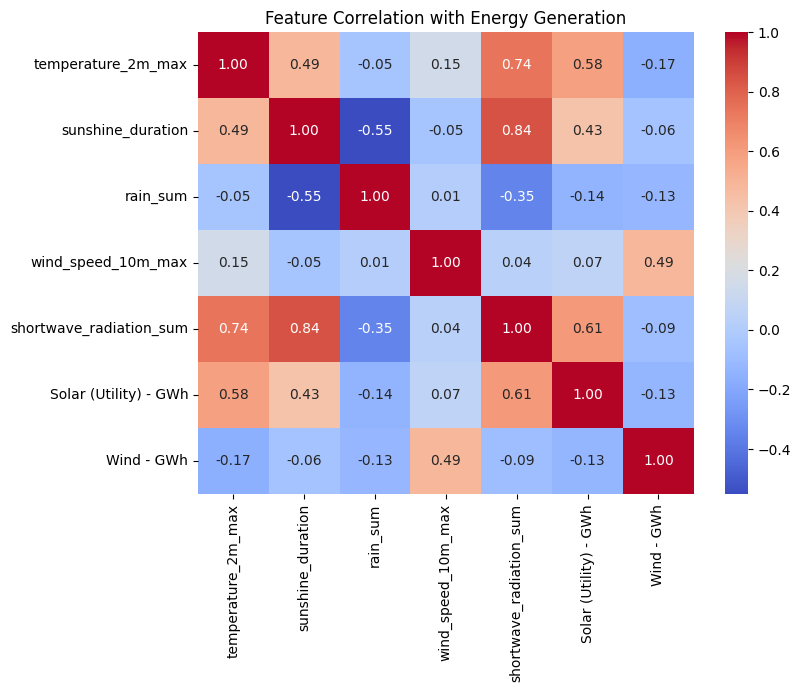

In [251]:
### Data Exploration: Check correlation between variables
import seaborn as sns
import matplotlib.pyplot as plt

# Merge WeatherData_df and EnergyGeneration_df on Date
merged_df = pd.merge(WeatherData_df, EnergyGeneration_clean_df, on="Date", how="inner")

# Select only relevant columns
# correlation_matrix = merged_df[["T2M", "WS50M", "WS50M_MAX", "WS10M_MAX", "ALLSKY_SFC_SW_DWN", "Solar (Utility) -  GWh", "Solar (Rooftop) -  GWh", "Wind -  GWh"]].corr()
# correlation_matrix = merged_df[["T2M","ALLSKY_SFC_SW_DWN","CLOUD_AMT", "QV2M", "wind_speed_10m_max","WS50M", "WS50M_MAX", "Solar (Utility) - GWh", "Wind - GWh"]].corr()
correlation_matrix = merged_df[["temperature_2m_max", "sunshine_duration", "rain_sum", "wind_speed_10m_max", "shortwave_radiation_sum", "Solar (Utility) - GWh", "Wind - GWh"]].corr()


# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation with Energy Generation")
plt.show()


We can see that for:
- solar generation - shortware radiation, temperature and sunshine duration have reasonable correlations.
- wind generation  - wind speed (10m) has a reasonable correlation.

## Model Building
#### 1. Linear Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

## First, create model for solar energy generation: Solar (Rooftop + Utility) - GWh
# Features: temperature, solar radiation, DOY (for seasonality)

# Select the features for the model
# WeatherData_avg = WeatherData_df.groupby('DOY')[['temperature_2m_max', 'shortwave_radiation_sum', 'wind_speed_10m_max']].mean().reset_index() # Group by DOY and take the average for these parameters
WeatherData_avg = WeatherData_df[['temperature_2m_max', 'shortwave_radiation_sum', 'wind_speed_10m_max']].mean().reset_index() # Group by DOY and take the average for these parameters

EnergyGeneration_clean_df = EnergyGeneration_clean_df.sort_values(by='DOY')

X = WeatherData_avg[['temperature_2m_max', 'shortwave_radiation_sum']]
# y = EnergyGeneration_clean_df['Solar (Utility) - GWh'] + EnergyGeneration_clean_df['Solar (Rooftop) - GWh']
y = EnergyGeneration_clean_df['Solar (Utility) - GWh']


# Data split, train model, predict
X_train, X_test, y_train, y_test_solar = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred_solar = model.predict(X_test)




## Second, create model for wind energy generation: Wind - GWh
# Features: wind speed

# Select the features for the model
# WeatherData_wind = WeatherData_df[WeatherData_df['isWindFarm'] == True] # Just select data for wind farms
WeatherData_avg_wind = WeatherData_df.groupby('DOY')[['wind_speed_10m_max']].mean().reset_index() # Group by DOY and take the average for wind speed
X = WeatherData_avg_wind[['wind_speed_10m_max']]  ** 1 # Wind generation is proportional to the cube of wind speed
y = EnergyGeneration_clean_df['Wind - GWh']

# Data split, train model, predict
X_train, X_test, y_train, y_test_wind = train_test_split(X, y, test_size=0.1, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred_wind = model.predict(X_test)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Solar plot
sns.scatterplot(x=y_test_solar, y=y_pred_solar, ax=axes[0])
axes[0].plot([y_test_solar.min(), y_test_solar.max()], [y_test_solar.min(), y_test_solar.max()], 'g--')  # Ideal 1:1 line
axes[0].set_xlabel("Actual Solar Generation (GWh)")
axes[0].set_ylabel("Predicted Solar Generation (GWh)")
axes[0].set_title("Predicted vs. Actual Solar Generation")

# Wind plot
sns.scatterplot(x=y_test_wind, y=y_pred_wind, ax=axes[1])
axes[1].plot([y_test_wind.min(), y_test_wind.max()], [y_test_wind.min(), y_test_wind.max()], 'g--')  # Ideal 1:1 line
axes[1].set_xlabel("Actual Wind Generation (GWh)")
axes[1].set_ylabel("Predicted Wind Generation (GWh)")
axes[1].set_title("Predicted vs. Actual Wind Generation")

plt.tight_layout()
plt.show()

print("Solar MAE:", mean_absolute_error(y_test_solar, y_pred_solar))
print("Wind MAE:", mean_absolute_error(y_test_wind, y_pred_wind))

ValueError: Found input variables with inconsistent numbers of samples: [366, 558]

##### Model Improvement Experiements
a. Incoorporate seasonality

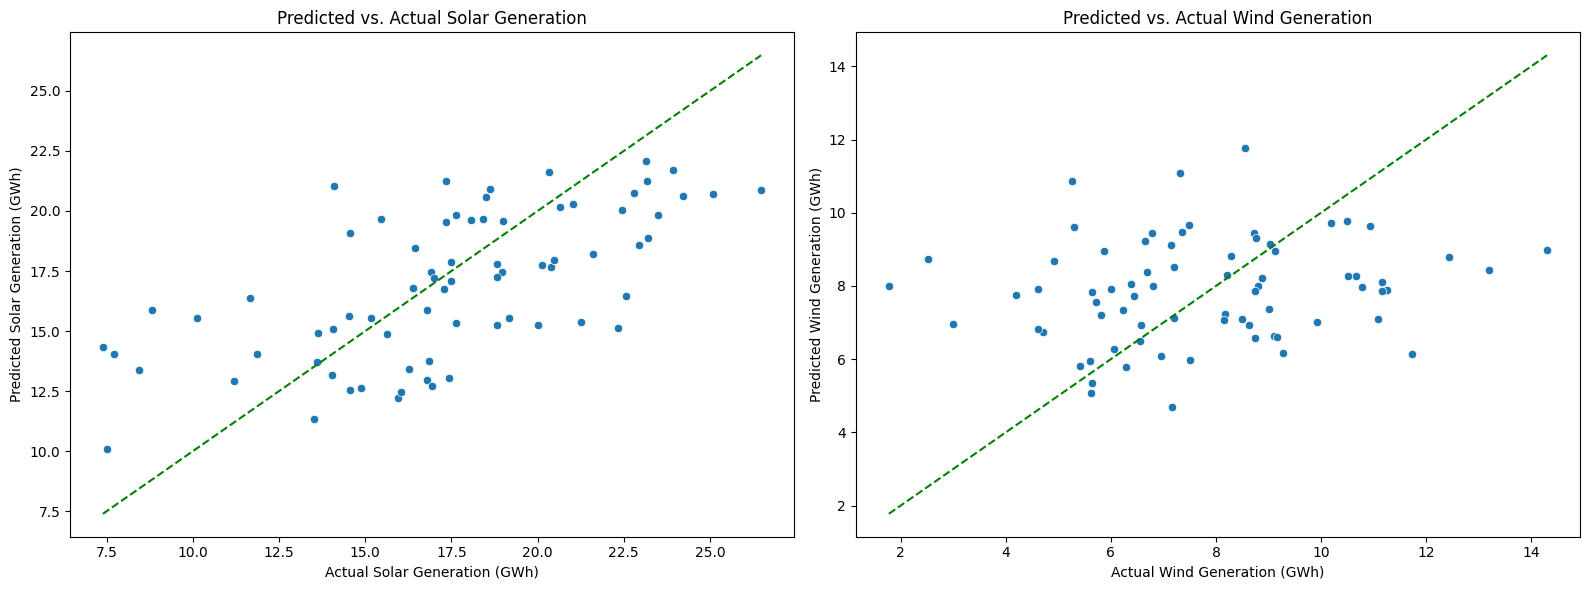

Solar MAE: 2.788240551546955
Wind MAE: 2.1034396633573764


In [230]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

## First, create model for solar energy generation: Solar (Rooftop + Utility) - GWh
# Features: temperature, solar radiation, DOY (for seasonality)

# Select the features for the model
# WeatherData_avg = WeatherData_df.groupby('DOY')[['temperature_2m_max', 'shortwave_radiation_sum', 'WS50M_MAX', 'WS50M','WS10M_MAX']].mean().reset_index() # Group by DOY and take the average for these parameters
WeatherData_avg = WeatherData_df.groupby('DOY')[['temperature_2m_max', 'shortwave_radiation_sum', 'wind_speed_10m_max']].mean().reset_index() # Group by DOY and take the average for these parameters

EnergyGeneration_clean_df = EnergyGeneration_clean_df.sort_values(by='DOY')

WeatherData_avg['DOY_sin'] = np.sin(2 * np.pi * WeatherData_avg['DOY'] / 365) # Encode DOY as sin/cos for seasonality
WeatherData_avg['DOY_cos'] = np.cos(2 * np.pi * WeatherData_avg['DOY'] / 365)

X = WeatherData_avg[['temperature_2m_max', 'shortwave_radiation_sum' , 'DOY_sin', 'DOY_cos']]
# y = EnergyGeneration_clean_df['Solar (Utility) -  GWh'] + EnergyGeneration_clean_df['Solar (Rooftop) -  GWh']
y = EnergyGeneration_clean_df['Solar (Utility) - GWh']

# Data split, train model, predict
X_train, X_test, y_train, y_test_solar = train_test_split(X, y, test_size=0.2, random_state=42)

Solar_LR_model = LinearRegression()
Solar_LR_model.fit(X_train, y_train)
y_pred_solar = Solar_LR_model.predict(X_test)




## Second, create model for wind energy generation: Wind - GWh
# Features: wind speed

# Select the features for the model
# WeatherData_wind = WeatherData_df[WeatherData_df['isWindFarm'] == True] # Just select data for wind farms
WeatherData_avg_wind = WeatherData_df.groupby('DOY')[['wind_speed_10m_max']].mean().reset_index() # Group by DOY and take the average for wind speed
# Encode DOY as sine and cosine components to capture seasonality
WeatherData_avg_wind['DOY_sin'] = np.sin(2 * np.pi * WeatherData_avg_wind['DOY'] / 365)
WeatherData_avg_wind['DOY_cos'] = np.cos(2 * np.pi * WeatherData_avg_wind['DOY'] / 365)

# Select the features for the model, including DOY components and wind speed
X = WeatherData_avg_wind[['wind_speed_10m_max', 'DOY_sin', 'DOY_cos']] ** 1  # Wind generation is proportional to the cube of wind speed
y = EnergyGeneration_clean_df['Wind - GWh']

# Data split, train model, predict
X_train, X_test, y_train, y_test_wind = train_test_split(X, y, test_size=0.2, random_state=42)

Wind_LR_model = LinearRegression()
Wind_LR_model.fit(X_train, y_train)
y_pred_wind = Wind_LR_model.predict(X_test)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Solar plot
sns.scatterplot(x=y_test_solar, y=y_pred_solar, ax=axes[0])
axes[0].plot([y_test_solar.min(), y_test_solar.max()], [y_test_solar.min(), y_test_solar.max()], 'g--')  # Ideal 1:1 line
axes[0].set_xlabel("Actual Solar Generation (GWh)")
axes[0].set_ylabel("Predicted Solar Generation (GWh)")
axes[0].set_title("Predicted vs. Actual Solar Generation")

# Wind plot
sns.scatterplot(x=y_test_wind, y=y_pred_wind, ax=axes[1])
axes[1].plot([y_test_wind.min(), y_test_wind.max()], [y_test_wind.min(), y_test_wind.max()], 'g--')  # Ideal 1:1 line
axes[1].set_xlabel("Actual Wind Generation (GWh)")
axes[1].set_ylabel("Predicted Wind Generation (GWh)")
axes[1].set_title("Predicted vs. Actual Wind Generation")

plt.tight_layout()
plt.show()

print("Solar MAE:", mean_absolute_error(y_test_solar, y_pred_solar))
print("Wind MAE:", mean_absolute_error(y_test_wind, y_pred_wind))

Improvements to the model can be seen for solar, which is in line with expectated correlation between solar generation and month of year (more in summer, less in winter).
However, the LR wind model saw a minor increase in MAE, which may imply wind generation is less/not affected by seasonality.

#### 2. Gradient Boosting (XGBoost)

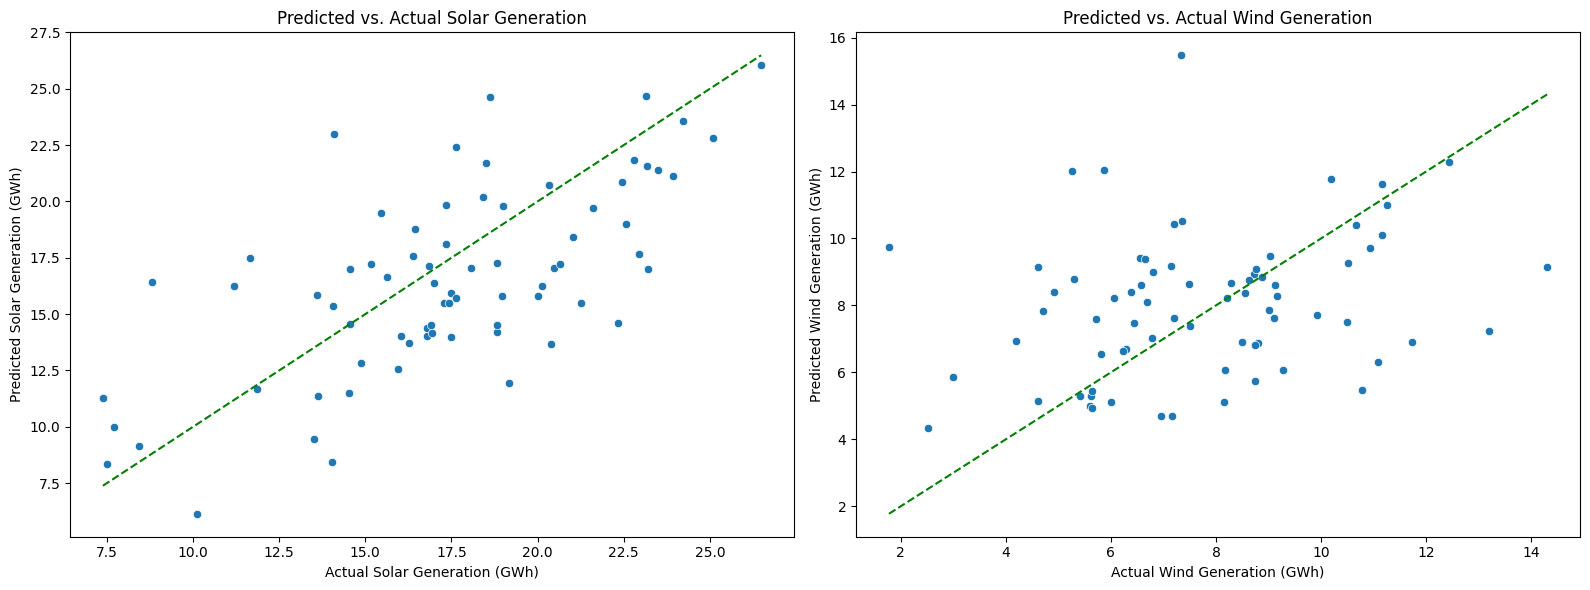

Solar MAE: 2.9272509794273063
Wind MAE: 2.048425302510301


In [231]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


## First, create model for solar energy generation: Solar (Rooftop + Utility) - GWh
# Features: temperature, solar radiation, DOY (for seasonality)

# Select the features for the model
# WeatherData_avg = WeatherData_df.groupby('DOY')[['temperature_2m_max', 'ALLSKY_SFC_SW_DWN', 'WS50M_MAX', 'WS50M', 'WS10M_MAX']].mean().reset_index() # Group by DOY and take the average for these parameters
WeatherData_avg = WeatherData_df.groupby('DOY')[['temperature_2m_max', 'shortwave_radiation_sum', 'wind_speed_10m_max']].mean().reset_index() # Group by DOY and take the average for these parameters

EnergyGeneration_clean_df = EnergyGeneration_clean_df.sort_values(by='DOY')

WeatherData_avg['DOY_sin'] = np.sin(2 * np.pi * WeatherData_avg['DOY'] / 365)  # Encode DOY as sin/cos for seasonality
WeatherData_avg['DOY_cos'] = np.cos(2 * np.pi * WeatherData_avg['DOY'] / 365)

X_solar = WeatherData_avg[['temperature_2m_max', 'shortwave_radiation_sum' , 'DOY_sin', 'DOY_cos']]
# y_solar = EnergyGeneration_clean_df['Solar (Utility) -  GWh'] + EnergyGeneration_clean_df['Solar (Rooftop) -  GWh']
y_solar = EnergyGeneration_clean_df['Solar (Utility) - GWh']

# Feature Scaling
scaler = StandardScaler()
X_solar_scaled = scaler.fit_transform(X_solar)

# Data split, train model, predict
X_train_solar, X_test_solar, y_train_solar, y_test_solar = train_test_split(X_solar_scaled, y_solar, test_size=0.2, random_state=42)

# Use XGBoost for Solar model
Solar_XG_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42)
Solar_XG_model.fit(X_train_solar, y_train_solar)
y_pred_solar = Solar_XG_model.predict(X_test_solar)






## Second, create model for wind energy generation: Wind - GWh
# Features: wind speed

# Select the features for the model
# WeatherData_wind = WeatherData_df[WeatherData_df['isWindFarm'] == True]  # Just select data for wind farms
WeatherData_avg_wind = WeatherData_df.groupby('DOY')[['wind_speed_10m_max']].mean().reset_index()  # Group by DOY and take the average for wind speed

# Encode DOY as sine and cosine components to capture seasonality
WeatherData_avg_wind['DOY_sin'] = np.sin(2 * np.pi * WeatherData_avg_wind['DOY'] / 365)
WeatherData_avg_wind['DOY_cos'] = np.cos(2 * np.pi * WeatherData_avg_wind['DOY'] / 365)

# Select the features for the model, including DOY components and wind speed
X_wind = WeatherData_avg_wind[['wind_speed_10m_max', 'DOY_sin', 'DOY_cos']] ** 1  # Wind generation is proportional to the cube of wind speed
y_wind = EnergyGeneration_clean_df['Wind - GWh']

# Feature Scaling
X_wind_scaled = scaler.fit_transform(X_wind)

# Data split, train model, predict
X_train_wind, X_test_wind, y_train_wind, y_test_wind = train_test_split(X_wind_scaled, y_wind, test_size=0.2, random_state=42)

# Use XGBoost for Wind model
Wind_XG_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42)
Wind_XG_model.fit(X_train_wind, y_train_wind)
y_pred_wind = Wind_XG_model.predict(X_test_wind)






# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Solar plot
sns.scatterplot(x=y_test_solar, y=y_pred_solar, ax=axes[0])
axes[0].plot([y_test_solar.min(), y_test_solar.max()], [y_test_solar.min(), y_test_solar.max()], 'g--')  # Ideal 1:1 line
axes[0].set_xlabel("Actual Solar Generation (GWh)")
axes[0].set_ylabel("Predicted Solar Generation (GWh)")
axes[0].set_title("Predicted vs. Actual Solar Generation")

# Wind plot
sns.scatterplot(x=y_test_wind, y=y_pred_wind, ax=axes[1])
axes[1].plot([y_test_wind.min(), y_test_wind.max()], [y_test_wind.min(), y_test_wind.max()], 'g--')  # Ideal 1:1 line
axes[1].set_xlabel("Actual Wind Generation (GWh)")
axes[1].set_ylabel("Predicted Wind Generation (GWh)")
axes[1].set_title("Predicted vs. Actual Wind Generation")

plt.tight_layout()
plt.show()

# Print performance metrics
print("Solar MAE:", mean_absolute_error(y_test_solar, y_pred_solar))
print("Wind MAE:", mean_absolute_error(y_test_wind, y_pred_wind))


#### 3. Seasonal Autoregressive Integrated Moving Average (SARIMA)

Uses energy generation history rather than weather variables (e.g. solar radiance, wind speed) to forecast solar & wind generation. Should be able to capture trends and seasonality.

In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# Read data from CSV
csv_path = os.path.join("SavedData", "PastEnergyGeneration.csv")
EnergyGeneration_df = pd.read_csv(csv_path)

# Convert to datetime and set as index
EnergyGeneration_df['Date'] = pd.to_datetime(EnergyGeneration_df['Date'])
EnergyGeneration_df.set_index('Date', inplace=True)

# Extract Solar and Wind time series
solar_ts = EnergyGeneration_df[EnergyGeneration_df['EnergyType'] == 'Solar']['ActualValue']
wind_ts = EnergyGeneration_df[EnergyGeneration_df['EnergyType'] == 'Wind']['ActualValue']




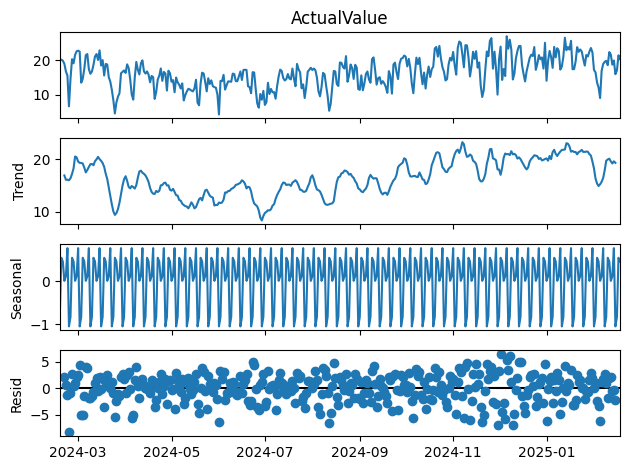

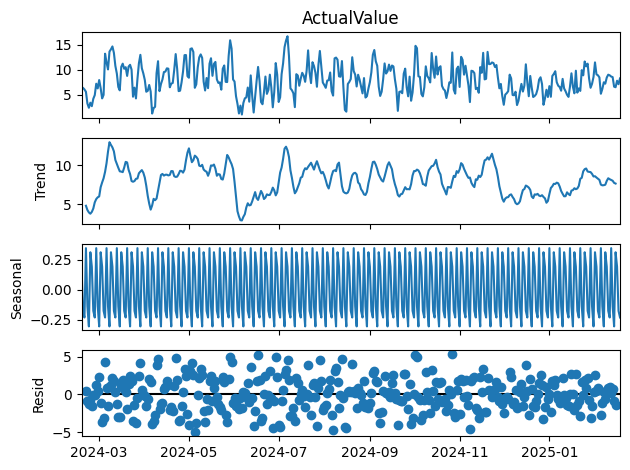

In [233]:
### Explore Time series to determine parameters for SARIMA model

## Check for seasonal differencing (D)
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose solar time series
result_solar = seasonal_decompose(solar_ts, model='additive')
result_solar.plot()

# Decompose wind time series
result_wind = seasonal_decompose(wind_ts, model='additive')
result_wind.plot()

plt.tight_layout()
plt.show()

## -- There is a clear seasonal trend for solar generation (12 month cycle) but not for wind generation -- ##

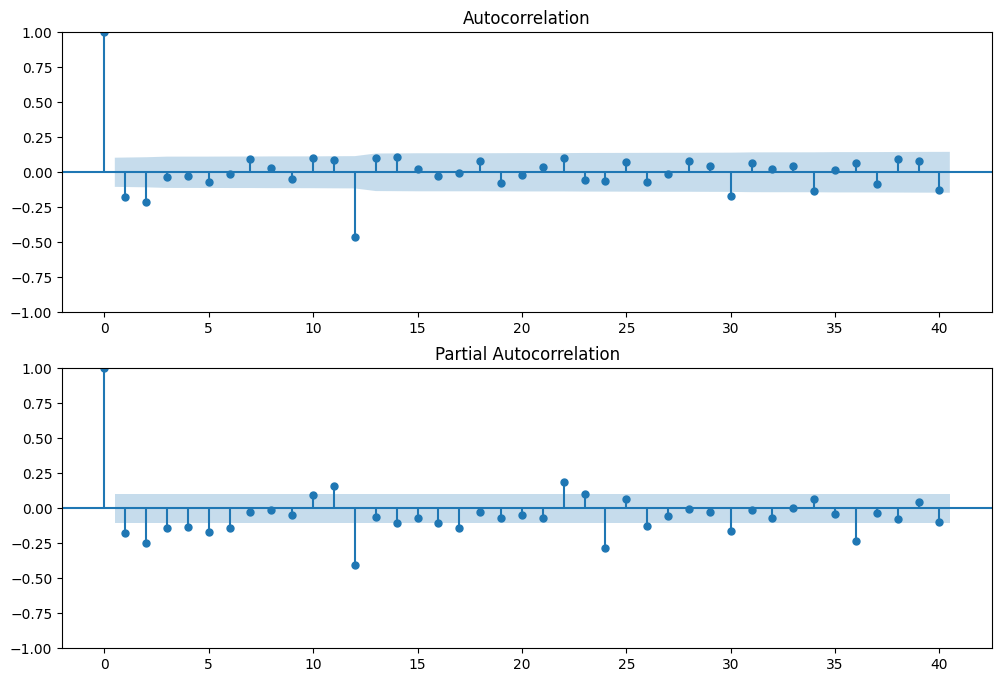

In [234]:
### For AR/MA order (p, q) determination, use ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Apply differencing
d = 1  
s = 12
D = 1 

stationary_series = solar_ts.diff(d).diff(s*D).dropna()

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(stationary_series, lags=40, ax=ax[0])
plot_pacf(stationary_series, lags=40, ax=ax[1], method='ywm')
plt.show()

c:\Users\Tom\OneDrive - Queensland University of Technology\Projects\Renewable-Energy-Generation-Prediction\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Tom\OneDrive - Queensland University of Technology\Projects\Renewable-Energy-Generation-Prediction\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Tom\OneDrive - Queensland University of Technology\Projects\Renewable-Energy-Generation-Prediction\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Tom\OneDrive - Queensland University of Technology\Projects\Renewable-Energy-Generation-Prediction\.venv\Lib\

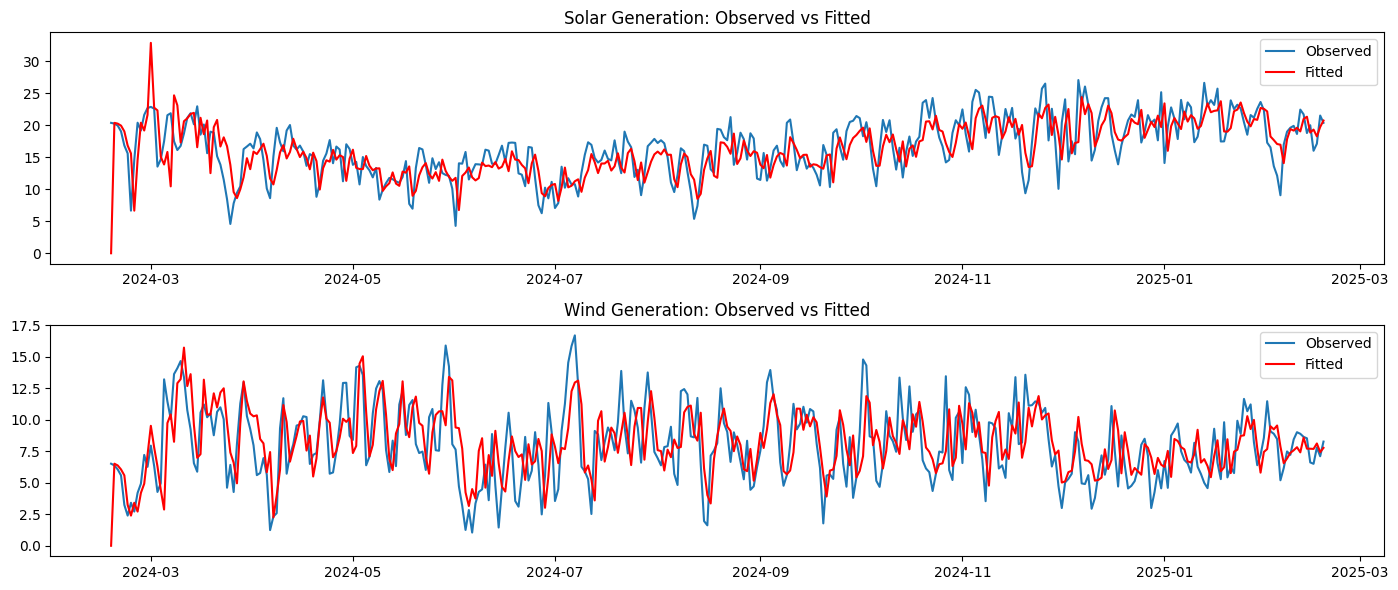

Solar MAE: 2.72 GWh
Wind MAE: 2.02 GWh


In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# Define SARIMA parameters (initial guess)
p, d, q = 1, 1, 1  # Non-seasonal AR, differencing, MA orders
P, D, Q, s = 1, 1, 1, 12  # Seasonal AR, differencing, MA orders, and seasonality (12 months)

# Fit SARIMA model for Solar
Solar_SARIMA_model = SARIMAX(solar_ts, order=(p, d, q), seasonal_order=(P, D, Q, s))
solar_results = Solar_SARIMA_model.fit(disp=False)

# Fit SARIMA model for Wind
Wind_SARIMA_model = SARIMAX(wind_ts, order=(p, d, q), seasonal_order=(P, D, Q, s))
wind_results = Wind_SARIMA_model.fit(disp=False)

# Plot results for Solar
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(solar_ts, label='Observed')
plt.plot(solar_results.fittedvalues, label='Fitted', color='red')
plt.title('Solar Generation: Observed vs Fitted')
plt.legend()

# Plot results for Wind
plt.subplot(2, 1, 2)
plt.plot(wind_ts, label='Observed')
plt.plot(wind_results.fittedvalues, label='Fitted', color='red')
plt.title('Wind Generation: Observed vs Fitted')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate model performance (using Mean Absolute Error)
solar_mae = mean_absolute_error(solar_ts, solar_results.fittedvalues)
wind_mae = mean_absolute_error(wind_ts, wind_results.fittedvalues)

print(f"Solar MAE: {solar_mae:.2f} GWh")
print(f"Wind MAE: {wind_mae:.2f} GWh")


## Energy Forecasts/Predictions

Forecasts for expected solar and wind energy generation in Queensland using 3 models:

In [236]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": -21,
	"longitude": 145,
	"daily": ["temperature_2m_max", "sunshine_duration", "wind_speed_10m_max", "shortwave_radiation_sum"],
	"wind_speed_unit": "ms",
	"timezone": "Australia/Sydney",
	# "past_days": 10
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
daily_sunshine_duration = daily.Variables(1).ValuesAsNumpy()
daily_wind_speed_10m_max = daily.Variables(2).ValuesAsNumpy()
daily_shortwave_radiation_sum = daily.Variables(3).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start=pd.to_datetime(daily.Time(), unit="s", utc=True).tz_convert('Australia/Sydney'),
	end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True).tz_convert('Australia/Sydney'),
	freq=pd.Timedelta(seconds=daily.Interval()),
	inclusive="left"
)}

daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["sunshine_duration"] = daily_sunshine_duration
daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
daily_data["shortwave_radiation_sum"] = daily_shortwave_radiation_sum



daily_dataframe = pd.DataFrame(data = daily_data)
print(daily_dataframe)

Coordinates -21.125°N 145.0°E
Elevation 265.0 m asl
Timezone b'Australia/Sydney' b'GMT+11'
Timezone difference to GMT+0 39600 s
                       date  temperature_2m_max  sunshine_duration  \
0 2025-02-20 00:00:00+11:00           32.834499       41542.687500   
1 2025-02-21 00:00:00+11:00           33.384502       42934.597656   
2 2025-02-22 00:00:00+11:00           32.784500       42292.964844   
3 2025-02-23 00:00:00+11:00           33.084499       41947.445312   
4 2025-02-24 00:00:00+11:00           33.984501       42785.105469   
5 2025-02-25 00:00:00+11:00           33.884502       42092.667969   
6 2025-02-26 00:00:00+11:00           34.684502       42646.125000   

   wind_speed_10m_max  shortwave_radiation_sum  
0            5.522680                21.930000  
1            6.985700                28.940001  
2            6.736468                26.540001  
3            6.906519                26.540001  
4            6.592420                28.219999  
5            6.50

##### Linear Regression

In [237]:
### Forecasting Energy Generation using linear regression
daily_dataframe['DOY'] = daily_dataframe['date'].dt.dayofyear
daily_dataframe['DOY_sin'] = np.sin(2 * np.pi * daily_dataframe['DOY'] / 365)
daily_dataframe['DOY_cos'] = np.cos(2 * np.pi * daily_dataframe['DOY'] / 365)

# daily_dataframe['temperature_2m_max'] = daily_dataframe['temperature_2m_max']
# daily_dataframe['shortwave_radiation_sum'] = daily_dataframe['shortwave_radiation_sum']
# daily_dataframe['wind_speed_10m_max'] = daily_dataframe['wind_speed_10m_max']


# -- Solar -- #
# x = daily_dataframe[['T2M','ALLSKY_SFC_SW_DWN', 'DOY_sin', 'DOY_cos']]
x = daily_dataframe[['temperature_2m_max','shortwave_radiation_sum', 'DOY_sin', 'DOY_cos']]
y_pred_solarLR = Solar_LR_model.predict(x)


# -- Wind -- #
x = daily_dataframe[['wind_speed_10m_max', 'DOY_sin', 'DOY_cos']] ** 1
y_pred_windLR = Wind_LR_model.predict(x)


print("Solar Generation Prediction:", y_pred_solarLR)
print("Wind Generation Prediction:", y_pred_windLR)

Solar Generation Prediction: [18.23052413 20.26196983 19.49052459 19.50257795 20.05955177 19.30701294
 19.928499  ]
Wind Generation Prediction: [7.29513772 8.85616727 8.61043202 8.80732079 8.4934413  8.41364619
 7.65357203]


##### Gradient Boosting

In [238]:
### Forecasting Energy Generation using linear regression
# -- Solar -- #
# x = daily_dataframe[['T2M','ALLSKY_SFC_SW_DWN', 'DOY_sin', 'DOY_cos']]
x = daily_dataframe[['temperature_2m_max','shortwave_radiation_sum', 'DOY_sin', 'DOY_cos']]
y_pred_solarGB = Solar_XG_model.predict(x)


# -- Wind -- #
x = daily_dataframe[['wind_speed_10m_max', 'DOY_sin', 'DOY_cos']] ** 1
y_pred_windGB = Wind_XG_model.predict(x)


print("Solar Generation Prediction:", y_pred_solarGB)
print("Wind Generation Prediction:", y_pred_windGB)

Solar Generation Prediction: [22.693096 23.174667 23.531498 23.529203 23.783493 23.713379 23.6694  ]
Wind Generation Prediction: [10.080083   9.681287  10.285232   7.8949013  7.8949013  7.746776
  7.746776 ]


##### SARIMA

In [239]:
# Perform SARIMA Forecasts
# -- Solar -- #
solar_forecast_sarima = solar_results.forecast(steps=7)  # Forecast for the next 7 periods
# -- Wind -- #
wind_forecast_sarima = wind_results.forecast(steps=7)  # Same for wind


print("Solar Generation SARIMA Forecast:", solar_forecast_sarima)
print("Wind Generation SARIMA Forecast:", wind_forecast_sarima)

Solar Generation SARIMA Forecast: 2025-02-19    19.543180
2025-02-20    19.892285
2025-02-21    19.354933
2025-02-22    19.511324
2025-02-23    19.548041
2025-02-24    19.302216
2025-02-25    19.606777
Freq: D, Name: predicted_mean, dtype: float64
Wind Generation SARIMA Forecast: 2025-02-19    8.220125
2025-02-20    7.865047
2025-02-21    7.940608
2025-02-22    7.501013
2025-02-23    6.534187
2025-02-24    7.159312
2025-02-25    6.883069
Freq: D, Name: predicted_mean, dtype: float64


## Save & Export Data

In [240]:
import os
import pandas as pd
from pathlib import Path

### --- Export the forecasted energy generation data to a CSV file --- ###
saved_data_dir = Path('SavedData')
forecast_csv_path = os.path.join('SavedData', 'ForecastEnergyGeneration.csv')
weather_csv_path = os.path.join('SavedData', 'WeatherForecast.csv')

# Load existing forecast data
if os.path.exists(forecast_csv_path):
    existing_forecast_df = pd.read_csv(forecast_csv_path, parse_dates=['Date'])
    existing_forecast_df['Date'] = existing_forecast_df['Date'].dt.strftime('%Y-%m-%d')
else:
    existing_forecast_df = pd.DataFrame()


start_date = daily_dataframe['date'].min() + pd.Timedelta(days=1)
date_range = pd.date_range(start=start_date, periods=7, freq='D')

# Create new forecast DataFrame
new_forecast_data = {
    "Date": date_range,
    "Solar Generation (LR)": y_pred_solarLR,
    "Wind Generation (LR)": y_pred_windLR,
    "Solar Generation (GB)": y_pred_solarGB,
    "Wind Generation (GB)": y_pred_windGB,
    "Solar Generation (SARIMA)": solar_forecast_sarima.values,
    "Wind Generation (SARIMA)": wind_forecast_sarima.values
}
new_forecast_df = pd.DataFrame(new_forecast_data)

# After creating new_forecast_df, reshape to long format
new_forecast_long = pd.melt(
    new_forecast_df,
    id_vars=["Date"],
    var_name="ModelEnergy",
    value_name="PredictedValue"
)

# Extract EnergyType and ModelType using regex
new_forecast_long[["EnergyType", "ModelType"]] = (
    new_forecast_long["ModelEnergy"]
    .str.extract(r'^(.*?) Generation \((.*?)\)$')
)

# Clean up and reorder columns
new_forecast_long = new_forecast_long[
    ["Date", "ModelType", "EnergyType", "PredictedValue"]
].dropna()
new_forecast_long['Date'] = new_forecast_long['Date'].dt.strftime('%Y-%m-%d')

# Convert existing data to long format if needed - only append if new data is available
if not existing_forecast_df.empty:
    if "Solar Generation (LR)" in existing_forecast_df.columns:
        existing_forecast_long = pd.melt(
            existing_forecast_df,
            id_vars=["Date"],
            var_name="ModelEnergy",
            value_name="PredictedValue"
        )
        existing_forecast_long[["EnergyType", "ModelType"]] = (
            existing_forecast_long["ModelEnergy"]
            .str.extract(r'^(.*?) Generation \((.*?)\)$')
        )
        existing_forecast_df = existing_forecast_long[
            ["Date", "ModelType", "EnergyType", "PredictedValue"]
        ].dropna()

        

# Combine and deduplicate

combined_forecast_df = pd.concat([existing_forecast_df, new_forecast_long])
combined_forecast_df = combined_forecast_df.drop_duplicates(
    subset=["Date", "ModelType", "EnergyType"], 
    keep="last"
)

# Save in long format
combined_forecast_df.to_csv(forecast_csv_path, index=False)



### --- Export the forecasted weather conditions to a CSV file --- ###
# Load existing weather data
if os.path.exists(weather_csv_path):
    existing_weather_df = pd.read_csv(weather_csv_path, parse_dates=['Date'])
    existing_weather_df['Date'] = existing_weather_df['Date'].dt.strftime('%Y-%m-%d')
else:
    existing_weather_df = pd.DataFrame()

# Prepare new weather data
new_weather_data = daily_dataframe[['date', 'temperature_2m_max', 'wind_speed_10m_max', 'shortwave_radiation_sum']].tail(7).copy()
new_weather_data.columns = ['Date', 'Max Temperature (°C)', 'Max Wind Speed (m/s)', 'Total Solar Radiation (MJ/m^2)']
new_weather_data['Date'] = new_weather_data['Date'].dt.strftime('%Y-%m-%d')

# Append & Save Only New Forecast Data
if not existing_weather_df.empty:
    combined_weather_df = pd.concat([existing_weather_df, new_weather_data])
    combined_weather_df.drop_duplicates(subset='Date', keep='last', inplace=True)
else:
    combined_weather_df = new_weather_data

# Convert dates to yyyy-mm-dd format for UTC+10 timezone
# combined_weather_df['Date'] = combined_weather_df['Date'].dt.strftime('%Y-%m-%d')

combined_weather_df.to_csv(weather_csv_path, index=False)

In [241]:
import os
import requests
import pandas as pd
from datetime import datetime, timedelta
from dotenv import load_dotenv

# Load the OE API token from the .env file
load_dotenv()
token = os.getenv("OPENELECTRICITY_API_KEY")

### --- Export the actual energy generation data to a CSV file --- ###

# Define the CSV file path
csv_path = os.path.join("SavedData", "PastEnergyGeneration.csv")

# Ensure the "SavedData" directory exists
os.makedirs("SavedData", exist_ok=True)

# Load existing data if the CSV file exists
if os.path.exists(csv_path):
    existing_data_df = pd.read_csv(csv_path, parse_dates=['Date'])
    last_date = existing_data_df['Date'].max()
    date_start = (last_date + timedelta(days=1)).strftime('%Y-%m-%d')
else:
    existing_data_df = pd.DataFrame()
    date_start = "2024-02-18"  # Default start date if no existing data

date_end = (datetime.now()).date()  # End date is today

# Don't need to fetch data if up-to-date
date_start_dt = datetime.strptime(date_start, '%Y-%m-%d').date()
if date_start_dt >= date_end:
    print("Data is already up-to-date.")
else:
    # Define the API endpoint and parameters
    api_url = "https://api.openelectricity.org.au/v4/data/network/NEM"
    params = {
        "interval": "1d",
        "date_start": date_start,
        "date_end": date_end,
        "primary_grouping": "network_region",
        "metrics": "energy",
        "secondary_grouping": "fueltech_group"
    }

    # Set the headers with the bearer token
    headers = {
        "Authorization": f"Bearer {token}"
    }

    # Fetch the data from the API
    response = requests.get(api_url, params=params, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()

        # Filter for Queensland's solar and wind energy data
        solar_data = []
        wind_data = []

        for item in data['data']:  # Iterate through the 'data' list
            for result in item['results']:  # Now access 'results'
                if result['columns']['region'] == 'QLD1':
                    if result['columns']['fueltech_group'] == 'solar':
                        for entry in result['data']:
                            solar_data.append({'Date': entry[0], 'Solar (Utility) - GWh': entry[1] / 1000}) # Convert MWh to GWh
                    elif result['columns']['fueltech_group'] == 'wind':
                        for entry in result['data']:
                            wind_data.append({'Date': entry[0], 'Wind - GWh': entry[1] / 1000})

        # Convert to DataFrames
        solar_df = pd.DataFrame(solar_data)
        wind_df = pd.DataFrame(wind_data)

        # Merge data on Date
        EnergyGeneration_df = pd.merge(solar_df, wind_df, on='Date', how='outer')
        EnergyGeneration_df['Date'] = pd.to_datetime(EnergyGeneration_df['Date'])
        EnergyGeneration_df['DOY'] = EnergyGeneration_df['Date'].dt.dayofyear
        EnergyGeneration_df['Date'] = EnergyGeneration_df['Date'].dt.strftime('%Y-%m-%d')   

        # Melt the new data (only solar and wind columns)
        actuals_long_new = pd.melt(
            EnergyGeneration_df,
            id_vars=["Date", "DOY"],
            value_vars=["Solar (Utility) - GWh", "Wind - GWh"],
            var_name="EnergyType",
            value_name="ActualValue"
        )

        # Clean energy type names in the new data
        actuals_long_new["EnergyType"] = actuals_long_new["EnergyType"]\
            .str.replace(" (Utility) - GWh", "", regex=False)\
            .str.replace(" - GWh", "")

        # Now, append the new data to the existing data (combine old and new)
        if not existing_data_df.empty:
            # Add the new data to the existing data (only add new rows based on the Date column)
            existing_data_df['Date'] = pd.to_datetime(existing_data_df['Date']).dt.strftime('%Y-%m-%d')
            combined_df = pd.concat([existing_data_df, actuals_long_new]).drop_duplicates(subset=['Date', 'EnergyType'], keep='last')
        else:
            combined_df = actuals_long_new


        # Save the updated DataFrame to CSV
        combined_df.to_csv(csv_path, index=False)
    else:
        print(f"Failed to fetch data: {response.status_code}")
